# 応用情報工学演習：Scikit-Learnマスターコース
## 実践編 配布用コードファイル

#### 基本ライブラリの読み込み

In [12]:
import os, sys
import glob

import warnings
warnings.simplefilter('ignore')

import numpy as np
from sklearn.metrics import accuracy_score
from PIL import Image

# 自作モジュールのインポート
from utils.train import evaluate_history, torch_seed, cal_consistency_weight
from utils.model import get_model
from utils.dataset import MyDataset

# 必要ライブラリのインポート
import matplotlib.pyplot as plt

# PyTorch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms

torch.cuda.empty_cache()

# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

np.random.seed(1)

### Cudaのチェック

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#### データ読み込み関数

In [14]:
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#                               このセルは変更を禁止します                                  #
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#-------------------------------------------------------------------------------------------#
#-                                  データ読み込み関数                                     -#
#-------------------------------------------------------------------------------------------#
def load_data_(root_dir='../data/gw_dataset'):
    """
    グループワーク用　学習用データ読み込み関数

    Args:
        * root_dir: 配布したgw_datasetへのパスを指定する (default: '../data/gw_dataset')
        
    Output:
        * X_train:  正解ラベル付き学習用画像   shape: (140x150,528)
                    1行あたり、画像1枚の画素値を格納したnp.array
                    画像140枚、各画像224x224=150,528次元のベクトル
                    
        * y_train:  X_trainの正解ラベル        shape: (140, )
                    クラス数は7　140枚分のクラスラベル（0～6）の整数が格納されている
        
        * X_trainu: 正解ラベルなし学習用画像   shape: (210x150,528)
                    形式はX_trainと同じ
                    
        * X_val:   正解ラベル付き検証用画像   shape: (70x150,528)
                    形式はX_trainと同じ
                    
        * y_val:    X_valの正解ラベル          shape: (70, )
                    形式はy_valと同じ                             
    """
    
    #----------------- 学習用データの読み込み -------------------#
    train_paths = sorted(glob.glob(os.path.join(root_dir, "train", "*.png")))
    
    X_train = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in train_paths])
    y_train = np.load(os.path.join(root_dir, "y_train.npy"))

    #------------ ラベルなし学習用データの読み込み --------------#
    trainu_paths = sorted(glob.glob(os.path.join(root_dir, "train-u", "*.png")))
    X_trainu = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in trainu_paths])
    
    #----------------- 検証用データの読み込み -------------------#
    val_paths = sorted(glob.glob(os.path.join(root_dir,"val", "*.png")))
    X_val = np.array([np.array(Image.open(p)).astype(np.float32).ravel() for p in val_paths])
    y_val = np.load(os.path.join(root_dir, "y_val.npy"))

    return X_train, y_train, X_trainu, X_val, y_val

In [15]:
### データ読み込み関数の実行
X_train, y_train, X_trainu, X_val, y_val = load_data_() # すべて必要な場合
print(X_train.shape, y_train.shape, X_trainu.shape, X_val.shape, y_val.shape)

# X_train, y_train, _, X_val, y_val = load_data_() # いらないデータがある場合
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(140, 150528) (140,) (210, 150528) (1210, 150528) (1210,)


#### 評価関数

In [16]:
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#                               このセルは変更を禁止します                                  #
#-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-#
#-------------------------------------------------------------------------------------------#
#-                                       評価関数                                          -#
#-------------------------------------------------------------------------------------------#

def eval_(y_pred):
    """
    グループワーク用　評価関数
    実行する前にy_valがglobalスコープに読み込まれている必要がある

    Args:
        * y_pred:   識別結果　y_valと同形式・同shapeでなければならない
    """

    try:
        y_val
    except NameError as e:
        print("y_valが読み込まれていません")
        
    assert y_pred.shape == y_val.shape, 'y_predとy_valのサイズが一致しません'
    
    print("valデータでの識別精度:{0:.3f}".format(accuracy_score(y_val, y_pred)))

### データの確認

In [17]:
# 分類先クラスのリスト作成
classes = [ '0', '1', '2', '3', '4', '5', '6']

# データを復元
X_train_reshaped = X_train.reshape(-1, 224, 224, 3)
X_val_reshaped = X_val.reshape(-1, 224, 224, 3)
X_trainu_reshaped = X_trainu.reshape(-1, 224, 224, 3)

# データセット作成
train_data = MyDataset(X_train_reshaped, y_train, type='no_trans')
val_data = MyDataset(X_val_reshaped, y_val, type='val')
trainu_data = MyDataset(X_trainu_reshaped, None, type='no_trans')

# データ件数確認
print(f'訓練データ: {len(train_data)}件')
print(f'ラベルなし訓練データ: {len(trainu_data)}件')
print(f'検証データ: {len(val_data)}件')

# データローダー作成
batch_size = 20
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
unlabeled_loader = DataLoader(trainu_data, batch_size=batch_size, shuffle=True)


訓練データ: 140件
ラベルなし訓練データ: 210件
検証データ: 1210件


### モデルの定義

In [18]:
# 試行回数
num_epochs = 100

# Consistency regularizationの重み
w = 0

# historyファイルを初期化する
history = np.zeros((0, 5), dtype=float)

# 学習モデル定義
model_name = "swin"
num_classes = len(classes)
net = get_model(model_name=model_name, num_classes=num_classes)

# 乱数初期化
torch_seed()

# GPUの利用
net = net.to(device)

# 学習率
lr = 1e-4

# 損失関数定義
ce = nn.CrossEntropyLoss()
mse = nn.MSELoss()

# 最適化関数定義
optimizer = optim.Adam(net.parameters(), lr=lr)

SwinTransformer(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): Permute()
      (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (1): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (1): SwinTransformerBlock(
       

### Π-model

In [19]:
# 弱い変換
weak_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 強い変換
strong_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(size=224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomGrayscale(p=0.3),  
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [20]:
history = np.zeros((0, 5), dtype=float)
base_epochs = len(history)
net.train()
out = False

# エポック内バッチ数
len_iter = len(train_loader)

for epoch in range(base_epochs, num_epochs + base_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0
    
    for i, ((x_l, y_l), x_u) in enumerate(zip(train_loader, unlabeled_loader)):
        # 全てGPUへ転送
        x_l, y_l, x_u = x_l.to(device), y_l.to(device), x_u.to(device)
        
        # ラベルありデータのデータ拡張
        x_l_weak = torch.stack([weak_transform(x_l[i].cpu()) for i in range(x_l.size(0))]).to(device)
        x_l_strong = torch.stack([strong_transform(x_l[i].cpu()) for i in range(x_l.size(0))]).to(device)
        
        # ラベルあり拡張データとラベルなしデータを結合
        x_weak = torch.cat([x_l_weak, x_u], dim=0)
        x_strong = torch.cat([x_l_strong, x_u], dim=0) 

        # ネットワークで学習する
        z_weak = net(x_weak)
        with torch.no_grad():
            z_strong = net(x_strong)
        
        # weak_transform の出力を教師ありデータの数分スライス
        z_l_weak = z_weak[:x_l.size(0)]  # ラベルあり部分の出力
        y_pred = z_l_weak.max(1)[1]  # 予測ラベル

        # z_weak, z_strong は raw logits なので
        p_weak = torch.softmax(z_weak, dim=1)
        p_strong = torch.softmax(z_strong, dim=1)
        
        # Lossの計算
        Lx = ce(z_l_weak, y_l)
        Lu = mse(p_weak, p_strong)

        # wをバッチ単位で更新
        global_step = epoch * len_iter + i
        w = cal_consistency_weight(global_step, init_ep=0, end_ep=num_epochs * len_iter, init_w=0.0, end_w=2.0)

        # 損失の合計
        loss = Lx + w * Lu / len(classes)

        # 異常値検知
        if loss > 1e8 or torch.isnan(loss):
            print(f"Lossが発散しました。epoch: {epoch+1}, batch: {i+1}")
            out = True
            break

        # 損失と精度の記録
        train_loss += loss.item()
        train_acc += (y_pred == y_l).sum().item()
        
        # 逆伝播と最適化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 検証データでの損失と精度計算
    net.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = ce(outputs, labels)
            val_loss += loss.item()
            _, preds = outputs.max(1)
            val_acc += (preds == labels).sum().item()

    # 平均損失と精度の計算
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)
    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = val_acc / len(val_loader.dataset)

    # エポック結果表示
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs+base_epochs}: "
                f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
                f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

    # 履歴更新
    history = np.vstack((history, [epoch + 1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc]))

    if avg_val_acc == 1.00:
        path = 'god.pth'
        torch.save(net.state_dict(), path)

    # 終了判定
    if out:
        break


Epoch 1/100: Train Loss: 0.0860, Train Acc: 0.4000, Val Loss: 0.0610, Val Acc: 0.7355
Epoch 11/100: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0085, Val Acc: 0.9455
Epoch 21/100: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0044, Val Acc: 0.9711
Epoch 31/100: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0042, Val Acc: 0.9752
Epoch 41/100: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0043, Val Acc: 0.9769
Epoch 51/100: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0041, Val Acc: 0.9785
Epoch 61/100: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0040, Val Acc: 0.9793
Epoch 71/100: Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0040, Val Acc: 0.9777
Epoch 81/100: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0041, Val Acc: 0.9793
Epoch 91/100: Train Loss: 0.0001, Train Acc: 1.0000, Val Loss: 0.0040, Val Acc: 0.9793


[初期状態] loss: 0.06102, accuracy: 0.73554
[最終状態] loss: 0.00399, accuracy: 0.97934


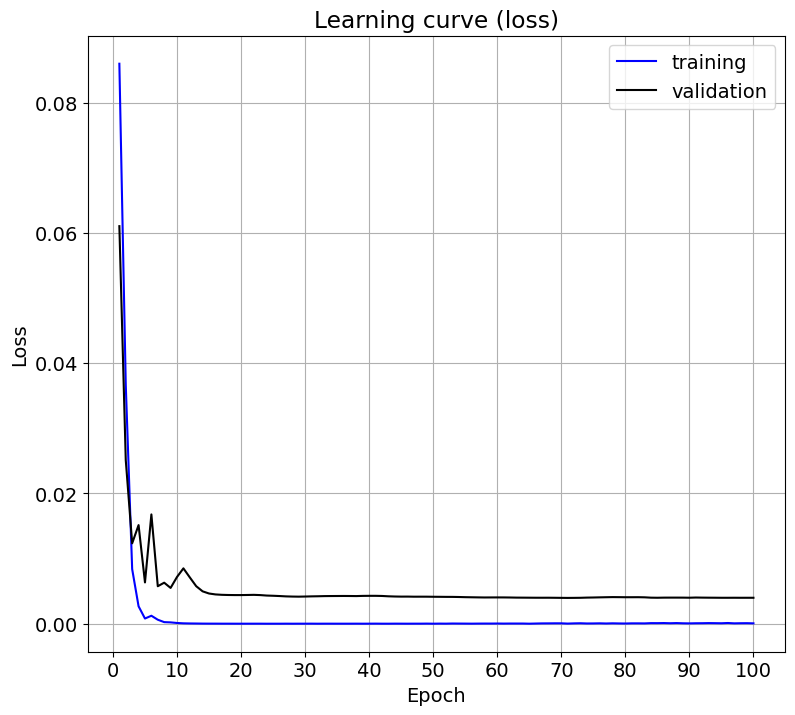

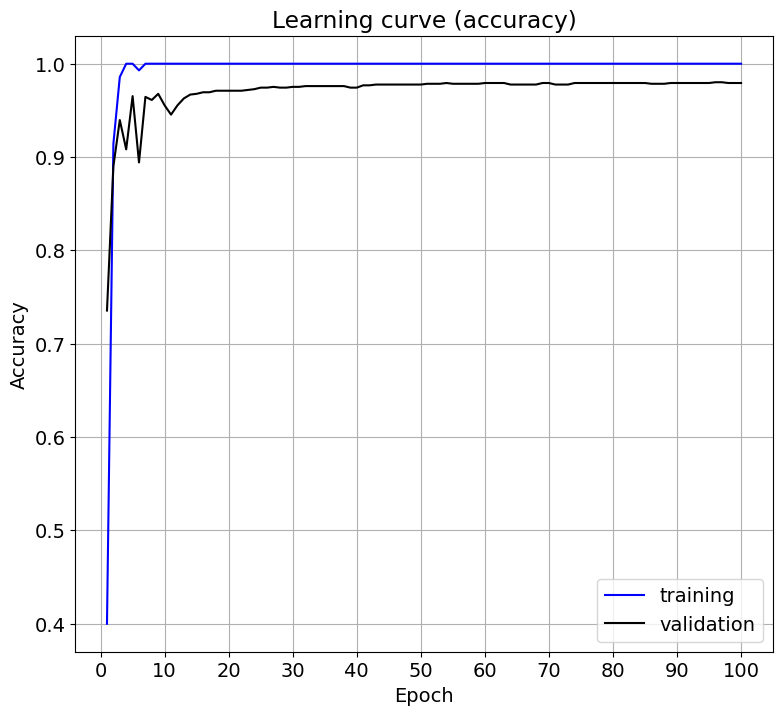

In [21]:
# 結果確認
evaluate_history(history)

### モデルの保存

In [22]:
path = 'model.pth'
torch.save(net.state_dict(), path)